In [1]:
# Start with loading all necessary libraries
import numpy as np
import pandas as pd
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from src.estimation import estimate_text_distribution
from collections import defaultdict
import spacy
nlp = spacy.load("en_core_web_lg")

def is_pos(word, pos):
    pos = pos.upper()
    doc = nlp(word)
    return any(token.pos_ == pos for token in doc)    

In [2]:
def combine_parquet_files():
    for data_type in ['human', 'ai']:
        # Initialize an empty list to store DataFrames
        dataframes = []
        
        # Read each Parquet file into a DataFrame and add it to the list
        for name in ["CS", "EESS", "Math", "Phys", "Stat"]:
            file_path = f"data/training_data/{name}/{data_type}_data.parquet"
            df = pd.read_parquet(file_path)
            dataframes.append(df)
        
        # Concatenate all DataFrames into a single DataFrame
        combined_df = pd.concat(dataframes, ignore_index=True)
        
        # Save the combined DataFrame to a new Parquet file
        combined_df.to_parquet(f"distribution/total_{data_type}.parquet", index=False)

def calculate_log_likelihood_ratio(log_likelihood_df):
    log_likelihood_df['log_likelihood_ratio'] = log_likelihood_df['logQ'] - log_likelihood_df['logP']
    return log_likelihood_df

combine_parquet_files()

In [3]:
# Run the estimate_text_distribution function
estimate_text_distribution('distribution/total_human.parquet', 'distribution/total_ai.parquet', 'distribution/log_likelihoods.parquet')

df = pd.read_parquet('distribution/log_likelihoods.parquet')
print(df)

                    Word       logP    log1-P       logQ    log1-Q
0              the realm  -9.660843 -0.000064  -3.347754 -0.035796
1               realm of  -9.565532 -0.000070  -3.273800 -0.038598
2          the intricate  -9.766203 -0.000057  -3.607075 -0.027506
3        researchers can -10.171668 -0.000038  -4.469831 -0.011515
4      valuable insights  -9.398478 -0.000083  -4.338587 -0.013141
...                  ...        ...       ...        ...       ...
70843          we obtain  -5.662642 -0.003479 -11.145969 -0.000014
70844           show the  -5.566498 -0.003831 -11.433651 -0.000011
70845         we develop  -5.250471 -0.005259 -11.145969 -0.000014
70846           we study  -4.533314 -0.010803 -11.433651 -0.000011
70847            we show  -3.748421 -0.023837 -11.145969 -0.000014

[70848 rows x 5 columns]


                    Word       logP    log1-P      logQ    log1-Q  \
0              the realm  -9.660843 -0.000064 -3.347754 -0.035796   
1               realm of  -9.565532 -0.000070 -3.273800 -0.038598   
2          the intricate  -9.766203 -0.000057 -3.607075 -0.027506   
3        researchers can -10.171668 -0.000038 -4.469831 -0.011515   
4      valuable insights  -9.398478 -0.000083 -4.338587 -0.013141   
..                   ...        ...       ...       ...       ...   
96     provides valuable  -9.883986 -0.000051 -6.206114 -0.002019   
97   scenarios involving -10.171668 -0.000038 -6.494393 -0.001513   
95              a deeper  -8.325842 -0.000242 -4.653729 -0.009572   
98           by offering  -9.883986 -0.000051 -6.216906 -0.001997   
100  theoretical physics -10.353990 -0.000032 -6.691622 -0.001242   

     log_likelihood_ratio  
0                6.313089  
1                6.291732  
2                6.159128  
3                5.701837  
4                5.059891  
.. 

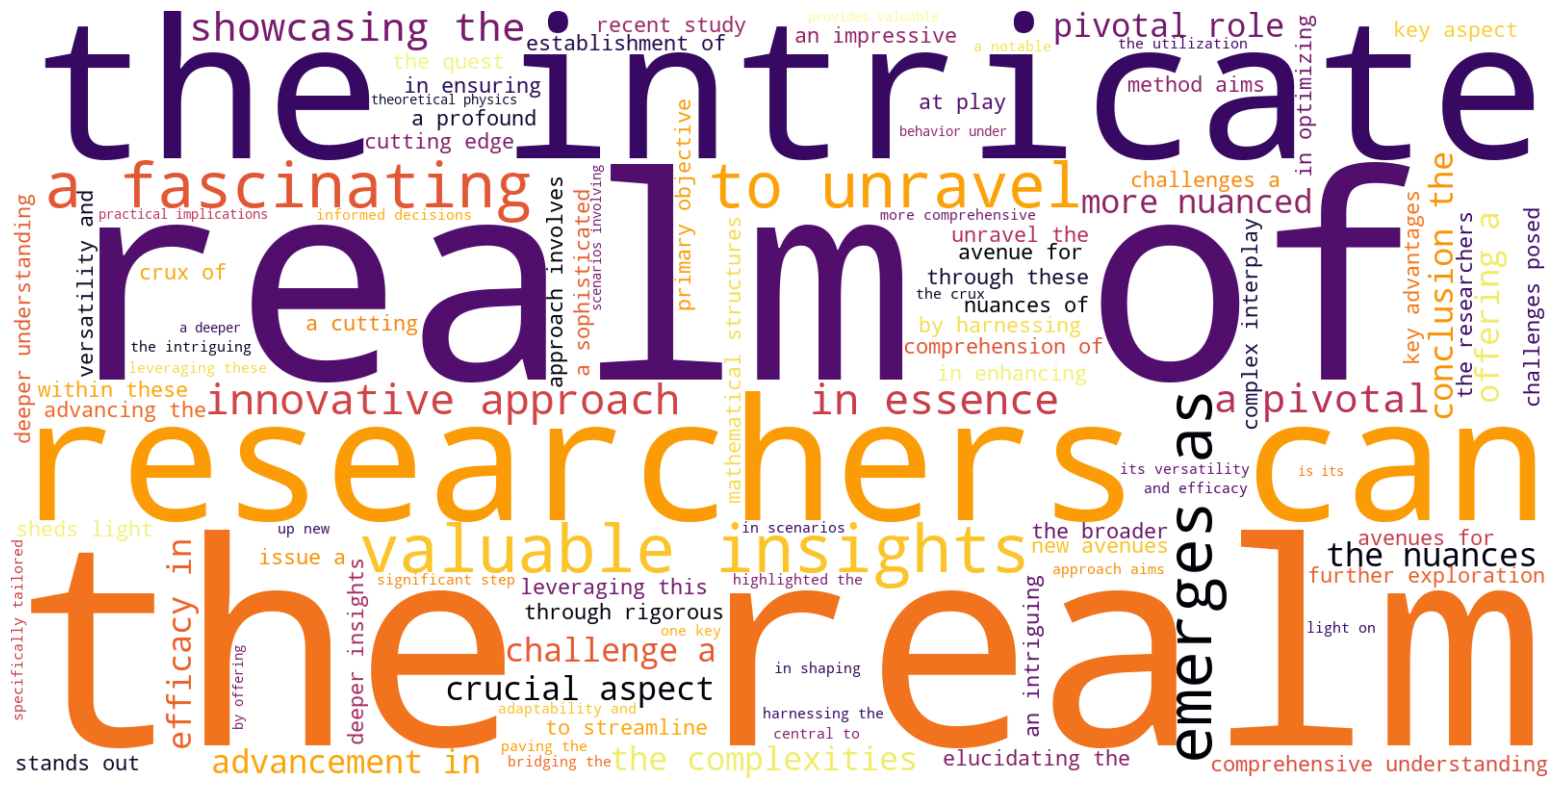

In [4]:
# Load the saved log likelihoods
log_likelihood_df = pd.read_parquet('distribution/log_likelihoods.parquet')

# Calculate the log likelihood ratio
log_likelihood_df = calculate_log_likelihood_ratio(log_likelihood_df)

# Sort the DataFrame by log likelihood ratio in descending order
sorted_df = log_likelihood_df.sort_values(by='log_likelihood_ratio', ascending=False)

# Filter words by the desired POS tag
#sorted_df = sorted_df[sorted_df['Word'].apply(lambda word: is_pos(word, 'ADV'))]

# Select the top 100 words
top_100_ai_words = sorted_df.head(100)

# Display the top 100 words
print(top_100_ai_words)
print(*top_100_ai_words['Word'])


word_freq = dict(zip(top_100_ai_words['Word'], top_100_ai_words['log_likelihood_ratio']))

# Create word cloud
wordcloud = wordcloud = WordCloud(
    width=1600,
    height=800,
    background_color='white',
    max_words=100,
    colormap='inferno',
    collocations=False,
    contour_color='black',
    contour_width=0.5
).generate_from_frequencies(word_freq)

# Display the word cloud
plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()